In [12]:
## Image augmentation
#!pip install imgaug

## ONLY used for dice metric and IOU metric computation, models are made from scratch
#!pip install -U segmentation-models

## Required to save models in HDF5 format
#!pip install pyyaml h5py

## Install nibabel
#!pip install nibabel

## Install scikit-learn library
#!pip install sklearn

## Install tensorflow and keras
#!pip uninstall tensorflow==2.2.0
#!pip install keras
#!pip install keras-segmentation

In [110]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn
import cv2 as cv
import nibabel as nib
import pickle
import glob
import imgaug as ia
import imgaug.augmenters as iaa
import tqdm
import gc, os
import warnings
import tensorflow as tf
from keras import backend as K
from keras import losses, metrics
from keras import optimizers
from keras import callbacks
from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Multiply
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from skimage import morphology
from skimage import measure
#import keras_segmentation as ks

warnings.filterwarnings('ignore')
%matplotlib inline
print("Version: ", tf.version.VERSION)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "not available")

Version:  1.15.0
GPU is not available


## 1. Loading data

In [3]:
datadir = '../training-set'
testdir = '../testing-set'

glob_search = os.path.join(datadir, 'patient*')
train_files = sorted(glob.glob(glob_search))
glob_search = os.path.join(testdir, 'patient*')
test_files = sorted(glob.glob(glob_search))

print('num of train patients {}, num of test patient {}'.format(len(train_files), len(test_files)))

num of train patients 19, num of test patient 1


# 2. EDA

### part one: Let's load images from the first patient and see what it looks like

CT filename:  ../training-set/patient01/patient01-ctscan.nii
number of slices:  301
image height is 512 and width is 512


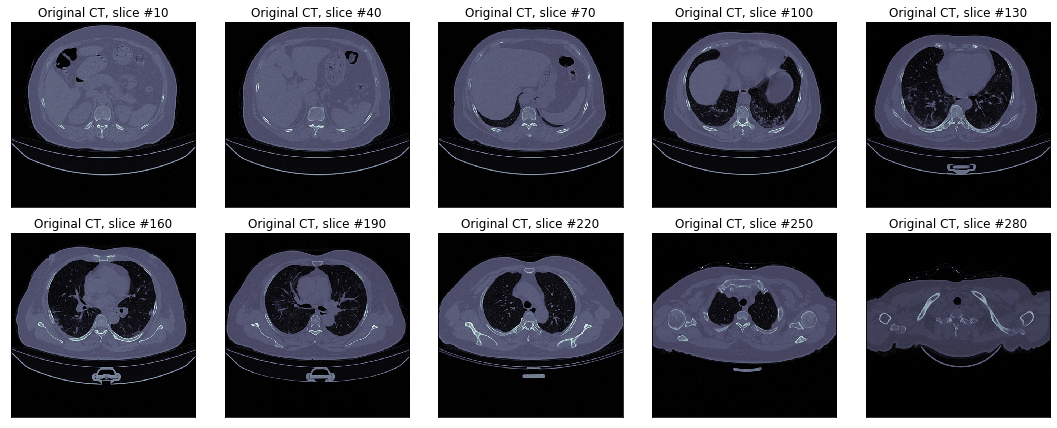

In [4]:
# img_size is the preferred image size to which the image is to be resized
img_size = 512

glob_search = os.path.join(train_files[0], '*ctscan*.nii')
ct_file = glob.glob(glob_search)
print('CT filename: ', ct_file[0])
cts = nib.load(ct_file[0])
data = cts.get_fdata()

height, width, slices = data.shape
print('number of slices: ', slices)
print('image height is {} and width is {}'.format(height, width))
  
# lets plot some of them
data = np.rot90(np.array(data))
data = np.reshape(np.rollaxis(data, 2),(slices,height,width))

sel_slices = range(10,slices,30)
arr = data[sel_slices, :, :]


fig, axes = plt.subplots(2, 5, figsize=(15,6))
axes = axes.flatten()
for ii in range(arr.shape[0]):
    img = cv.resize(arr[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    axes[ii].imshow(img, cmap='bone')
    axes[ii].set_title("Original CT, slice #{}".format(sel_slices[ii]))
    axes[ii].set_xticks([])
    axes[ii].set_yticks([]);
plt.tight_layout()

Now we are going to enhance the imaes and drop the first and last 20% of slices

In [5]:
clahe = cv.createCLAHE(clipLimit=3.0)

def clahe_enhancer(img, clahe, axes):
    '''Contrast Limited Adaptive Histogram Equalizer'''
    img = np.uint8(img*255)  
    clahe_img = clahe.apply(img)

    if len(axes) > 0 :    
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT")
        axes[0].set_xticks([]); axes[0].set_yticks([])

        axes[1].imshow(clahe_img, cmap='bone')
        axes[1].set_title("CLAHE Enhanced CT")
        axes[1].set_xticks([]); axes[1].set_yticks([])

        if len(axes) > 2 :
            axes[2].hist(img.flatten(), alpha=0.4, label='Original CT')
            axes[2].hist(clahe_img.flatten(), alpha=0.4, label="CLAHE Enhanced CT")
            plt.legend()
        
    return(clahe_img)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


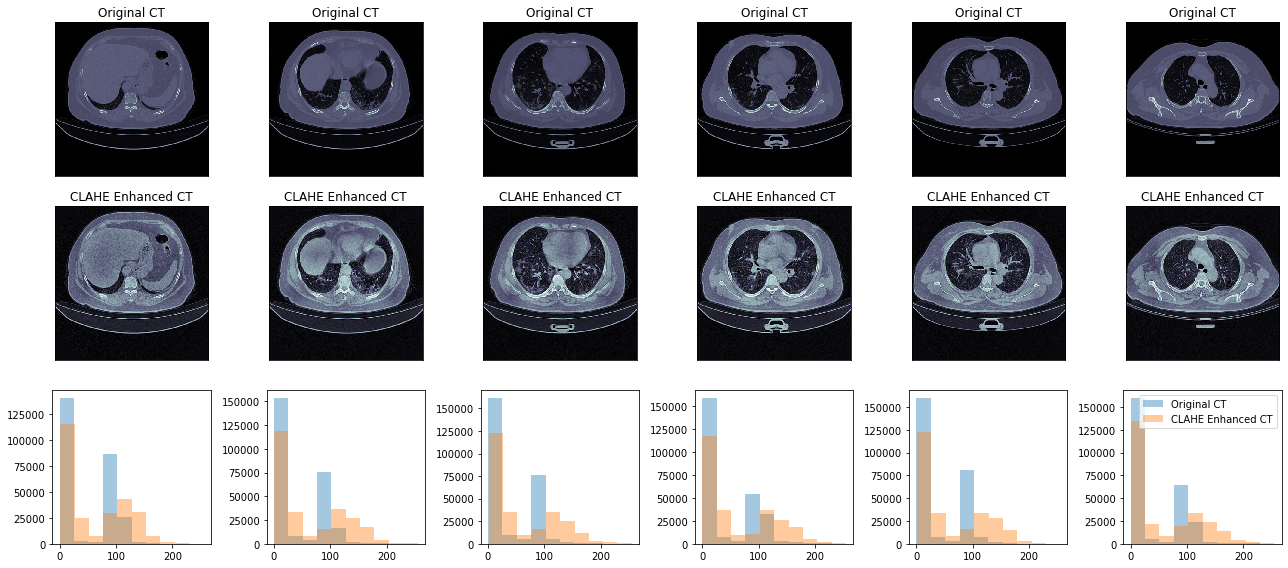

In [6]:
sel_slices = range(70, 240, 30)
arr = data[sel_slices, :, :]

fig, axes = plt.subplots(3, 6, figsize=(18,8))    
for ii in range(arr.shape[0]):
    img = cv.resize(arr[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    clahe_img = clahe_enhancer(img, clahe, list(axes[:, ii]))
plt.tight_layout()

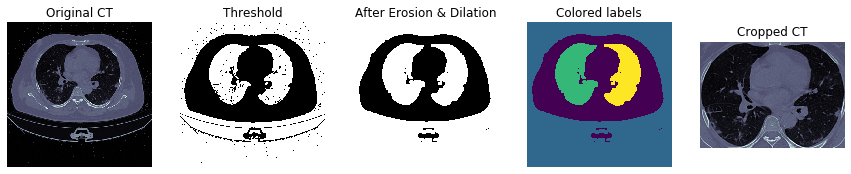

In [75]:
def crop_(img, boundaries):
    minx, miny, maxx, maxy = boundaries
    return img[minx:maxx, miny:maxy]

def make_lungmask(img, img_size=512, display_flag=False):
    height, width = img.shape
    img = (img-np.mean(img))/np.std(img)

    # Find the average pixel value near the lungs
    middle = img[int(width/5):int(width/5*4),int(height/5):int(height/5*4)] 
    mean = np.mean(middle)  
    imgmax = np.max(img)
    imgmin = np.min(img)
    
    img[img==imgmax]=mean
    img[img==imgmin]=mean
    
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.
    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    try :
        Lung1 = regions[1].bbox
        Lung2 = regions[2].bbox
        bounds = [min(Lung1[0], Lung2[0]), min(Lung1[1], Lung2[1]),
                  max(Lung1[2], Lung2[2]), max(Lung1[3], Lung2[3])]
    except :
        bounds = [img_size, img_size, 0, 0] # return extreme values

    if display_flag:
        fig, ax = plt.subplots(1, 5, figsize=[15, 3])
        ax[0].set_title("Original CT")
        ax[0].imshow(img, cmap='bone')
        ax[0].axis('off')
        ax[1].set_title("Threshold")
        ax[1].imshow(thresh_img, cmap='bone')
        ax[1].axis('off')
        ax[2].set_title("After Erosion & Dilation")
        ax[2].imshow(dilation, cmap='bone')
        ax[2].axis('off')
        ax[3].set_title("Colored labels")
        ax[3].imshow(labels)
        ax[3].axis('off')
        ax[4].set_title("Cropped CT")
        ax[4].imshow(crop_(img, bounds), cmap='bone')
        ax[4].axis('off')
        plt.show()
        
    return bounds

bounds = make_lungmask(arr[3], display_flag=True)

**Define helper functions**

There are a lot of empty spac in the images that can be cropped out. This makes the model run faster!

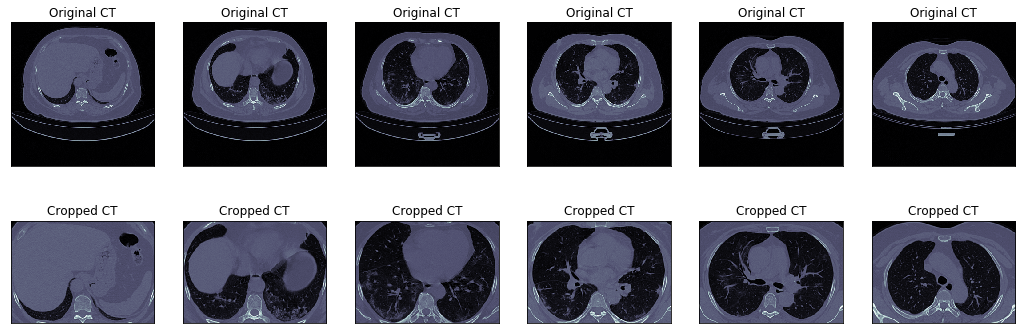

In [78]:
sel_slices = range(70, 240, 30)
arr = data[sel_slices, :, :]

bounds = [img_size, img_size, 0, 0]
for ii in range(arr.shape[0]) :
    img = cv.resize(arr[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    B = make_lungmask(img, img_size=img_size, display_flag=False)
    bounds[0] = min(bounds[0], B[0])
    bounds[1] = min(bounds[1], B[1])
    bounds[2] = max(bounds[2], B[2])
    bounds[3] = max(bounds[3], B[3])
    
    
fig, axes = plt.subplots(2, 6, figsize=(18,6))    
for ii in range(arr.shape[0]):
    img = cv.resize(arr[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    axes[0,ii].imshow(img, cmap='bone')
    axes[0,ii].set_title('Original CT')
    axes[0,ii].set_xticks([]); axes[0,ii].set_yticks([])
    
    img = crop_(img, bounds)
    axes[1,ii].imshow(img, cmap='bone')
    axes[1,ii].set_title('Cropped CT')
    axes[1,ii].set_xticks([]); axes[1,ii].set_yticks([])


### part two: Visualizing sample lung and infection masks

CT filename:  ../training-set/patient01/patient01-ctscan.nii
Lung mask filename:  ../training-set/patient01/patient01-lung_mask.nii
Infection mask filename:  ../training-set/patient01/patient01-infection_mask.nii


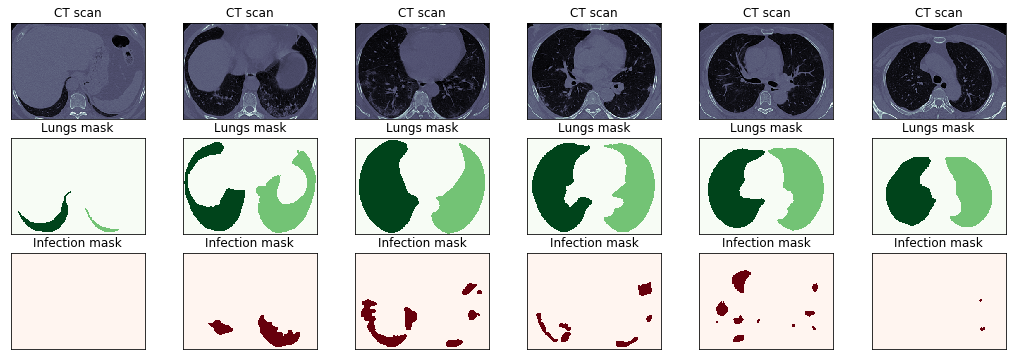

In [79]:
glob_search = os.path.join(train_files[0], '*ctscan*.nii')
ct_file = glob.glob(glob_search)
print('CT filename: ', ct_file[0])
cts = nib.load(ct_file[0])
data_cts = cts.get_fdata()

glob_search = os.path.join(train_files[0], '*lung*.nii')
lung_file = glob.glob(glob_search)
print('Lung mask filename: ', lung_file[0])
lung_masks = nib.load(lung_file[0])
data_lungs = lung_masks.get_fdata()

glob_search = os.path.join(train_files[0], '*infection*.nii')
infect_file = glob.glob(glob_search)
print('Infection mask filename: ', infect_file[0])
infect_masks = nib.load(infect_file[0])
data_infects = infect_masks.get_fdata()

height, width, slices = data_cts.shape
sel_slices = range(70, 240, 30)

data_cts = np.rot90(np.array(data_cts))
data_lungs = np.rot90(np.array(data_lungs))
data_infects = np.rot90(np.array(data_infects))

data_cts = np.reshape(np.rollaxis(data_cts, 2), (slices,height,width))
data_lungs = np.reshape(np.rollaxis(data_lungs, 2), (slices,height,width))
data_infects = np.reshape(np.rollaxis(data_infects, 2), (slices,height,width))

data_cts = data_cts[sel_slices, :, :]
data_lungs = data_lungs[sel_slices, :, :]
data_infects = data_infects[sel_slices, :, :]

bounds = [img_size, img_size, 0, 0]
for ii in range(data_cts.shape[0]) :
    img = cv.resize(data_cts[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    B = make_lungmask(img, img_size=img_size, display_flag=False)
    bounds[0] = min(bounds[0], B[0])
    bounds[1] = min(bounds[1], B[1])
    bounds[2] = max(bounds[2], B[2])
    bounds[3] = max(bounds[3], B[3])
    
fig, axes = plt.subplots(3, 6, figsize=(18,6))    
for ii in range(data_cts.shape[0]):
    img_ct = cv.resize(data_cts[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    img_lungs = cv.resize(data_lungs[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    img_infec = cv.resize(data_infects[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)

    axes[0,ii].imshow(crop_(img_ct, bounds), cmap='bone')
    axes[0,ii].set_title("CT scan")
    axes[0,ii].set_xticks([]); axes[0,ii].set_yticks([])
    
    axes[1,ii].imshow(crop_(img_lungs, bounds), cmap='Greens')
    axes[1,ii].set_title("Lungs mask")
    axes[1,ii].set_xticks([]); axes[1,ii].set_yticks([])

    axes[2,ii].imshow(crop_(img_infec, bounds), cmap='Reds')
    axes[2,ii].set_title("Infection mask")
    axes[2,ii].set_xticks([]); axes[2,ii].set_yticks([])

# 3. Load all the data

In [80]:
cts_all = []
lungs_all = []
infects_all = []

for fnum in tqdm.tqdm(range(len(train_files))) :
    glob_search = os.path.join(train_files[fnum], '*ctscan*.nii')
    ct_file = glob.glob(glob_search)
    cts = nib.load(ct_file[0])
    data_cts = cts.get_fdata()

    glob_search = os.path.join(train_files[fnum], '*lung*.nii')
    lung_file = glob.glob(glob_search)
    lung_masks = nib.load(lung_file[0])
    data_lungs = lung_masks.get_fdata()

    glob_search = os.path.join(train_files[fnum], '*infection*.nii')
    infect_file = glob.glob(glob_search)
    infect_masks = nib.load(infect_file[0])
    data_infects = infect_masks.get_fdata()

    height, width, slices = data_cts.shape
    sel_slices = range(round(slices*0.2), round(slices*0.8))

    data_cts = np.rot90(np.array(data_cts))
    data_lungs = np.rot90(np.array(data_lungs))
    data_infects = np.rot90(np.array(data_infects))

    data_cts = np.reshape(np.rollaxis(data_cts, 2), (slices,height,width))
    data_lungs = np.reshape(np.rollaxis(data_lungs, 2), (slices,height,width))
    data_infects = np.reshape(np.rollaxis(data_infects, 2), (slices,height,width))

    data_cts = data_cts[sel_slices, :, :]
    data_lungs = data_lungs[sel_slices, :, :]
    data_infects = data_infects[sel_slices, :, :]

    bounds = [img_size, img_size, 0, 0]
    for ii in range(data_cts.shape[0]) :
        img = cv.resize(data_cts[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
        B = make_lungmask(img, img_size=img_size, display_flag=False)
        bounds[0] = min(bounds[0], B[0])
        bounds[1] = min(bounds[1], B[1])
        bounds[2] = max(bounds[2], B[2])
        bounds[3] = max(bounds[3], B[3])

    for ii in range(data_cts.shape[0]):
        img = cv.resize(data_cts[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
        cp_img = crop_(img, bounds)
        cts_all.append(cp_img)
        
        img = cv.resize(data_lungs[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
        cp_img = crop_(img, bounds)
        lungs_all.append(cp_img)

        img = cv.resize(data_infects[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
        cp_img = crop_(img, bounds)
        infects_all.append(cp_img)

100%|██████████| 19/19 [13:22<00:00, 42.21s/it]


In [82]:
print('Total numer of slices: {}'.format(len(cts_all)))

Total numer of slices: 2057


# 4. Resize and reshape

To speed up the training, we are going to downsample images to 100x100. This, however, may reduce network performance.

In [83]:
num_pix = 100
del_lst = []
for ii in tqdm.tqdm(range(len(cts_all))) :
    try :
        cts_all[ii] = cv.resize(cts_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        cts_all[ii] = np.reshape(cts_all[ii], (num_pix, num_pix, 1))

        lungs_all[ii] = cv.resize(lungs_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        lungs_all[ii] = np.reshape(lungs_all[ii], (num_pix, num_pix, 1))

        infects_all[ii] = cv.resize(infects_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        infects_all[ii] = np.reshape(infects_all[ii], (num_pix, num_pix, 1))
    except :
        del_lst.append(ii)
        
for idx in del_lst[::-1] :
    del cts_all[idx]
    del lungs_all[idx]
    del infects_all[idx]

100%|██████████| 2057/2057 [00:12<00:00, 159.87it/s]


**Visualizing a preprocessed sample**

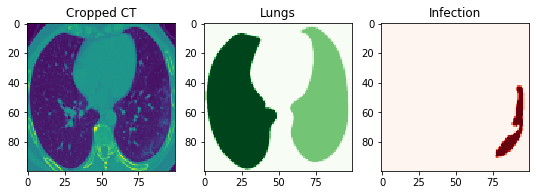

In [86]:
fig, axes = plt.subplots(1, 3, figsize=(9,3))

axes[0].imshow(cts_all[450][:, :, 0])
axes[0].set_title("Cropped CT")

axes[1].imshow(lungs_all[450][:, :, 0], cmap='Greens')
axes[1].set_title("Lungs")

axes[2].imshow(infects_all[450][:, :, 0], cmap='Reds')
axes[2].set_title("Infection");

**<font color='blue'>Notice how the infection can be distinguised clearly after enhancement.**

### Dump the preprocessed data

In [87]:
with open('../outputs/preprocessed_data.cp', 'wb') as myfile:
    pickle.dump({'cts': cts_all, 'lungs': lungs_all, 'infects': infects_all}, myfile)

In [88]:
infect_bool = np.ones((1, len(infects_all)))
for ii in range(len(infects_all)):
    if np.unique(infects_all[ii]).size == 1:
        infect_bool[0, ii] = 0
        
print("Number of CTs with no infection: {:03d}".format(len(infects_all)-int(infect_bool.sum())))

#for index in sorted(no_masks, reverse = True):  
#    del infections[index]  
#    del cts[index]

Number of CTs with no infection: 564


* Saving the numpy arrays to later reuse the same preprocessing for other models rather than doing it again.


# 5. Data augmentation pipeline

In [89]:
ia.seed(1)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Flipud(0.5), # vertical flips
    
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-15, 15),
        shear=(-15, 15)
    )
], random_order=True) # apply augmenters in random order

In [90]:
num_augs = round(len(cts_all)/2.)
rand_idx = np.random.randint(0, len(cts_all), size=num_augs)

sample_cts = [cts_all[ii] for ii in rand_idx]
sample_lungs = [lungs_all[ii] for ii in rand_idx]
sample_infects = [infects_all[ii] for ii in rand_idx]

In [91]:
seq_det = seq.to_deterministic()
cts_aug = seq_det.augment_images(sample_cts)
lungs_aug = seq_det.augment_images(sample_lungs)
infects_aug = seq_det.augment_images(sample_infects)

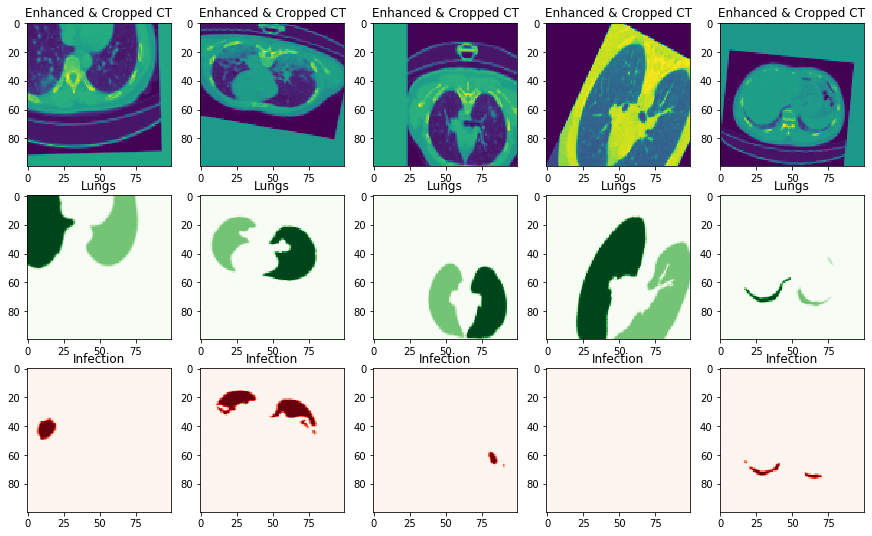

In [92]:
fig, axes = plt.subplots(3, 5, figsize=(15,9))
for ii in range(5) :
    axes[0, ii].imshow(cts_aug[ii*50][:, :, 0])
    axes[0, ii].set_title("Enhanced & Cropped CT")

    axes[1, ii].imshow(lungs_aug[ii*50][:, :, 0], cmap='Greens')
    axes[1, ii].set_title("Lungs")

    axes[2, ii].imshow(infects_aug[ii*50][:, :, 0], cmap='Reds')
    axes[2, ii].set_title("Infection");

#### Pool augmented data and convert it

In [102]:
cts_all = tf.convert_to_tensor(np.asarray(cts_all))
cts_aug = tf.convert_to_tensor(np.asarray(cts_aug))
lungs_all = tf.convert_to_tensor(np.asarray(lungs_all))
lungs_aug = tf.convert_to_tensor(np.asarray(lungs_aug))
infects_all = tf.convert_to_tensor(np.asarray(infects_all))
infects_aug = tf.convert_to_tensor(np.asarray(infects_aug))

cts = tf.concat([cts_all, cts_aug], axis=0)
lungs = tf.concat([lungs_all, lungs_aug], axis=0)
infects = tf.concat([infects_all, infects_aug], axis=0)

In [103]:
indices = tf.range(start=0, limit=cts.shape[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)
                       
cts = tf.gather(cts, shuffled_indices)
lungs = tf.gather(lungs, shuffled_indices)
infects = tf.gather(infects, shuffled_indices)

print(cts.shape, lungs.shape, infects.shape)

(3085, 100, 100, 1) (3085, 100, 100, 1) (3085, 100, 100, 1)


#### Save augmented data

In [118]:
np.save('../outputs/augmented_data.npy', 
        {'cts': cts, 'lungs': lungs, 'infects': infects})

**Just overlaying infection masks over the corresponding CT scans**

In [119]:
def plot_cts_infects(ct, infect, axes) :

    axes[0].imshow(ct[:,:,0], cmap='bone')
    axes[0].set_title('CT image')

    axes[1].imshow(ct[:,:,0], cmap='bone')
    axes[1].imshow(infect[:,:,0], alpha=0.5, cmap='Reds')
    axes[1].set_title('Infection')

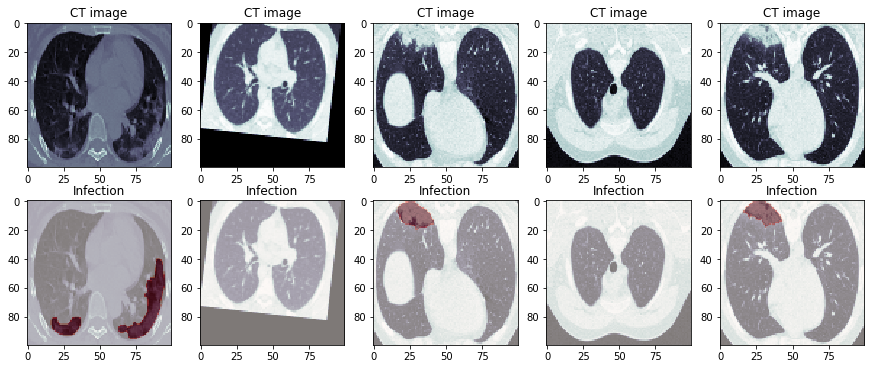

In [122]:
fig, axes = plt.subplots(2, 5, figsize=(15,6))

for ii, idx in enumerate(range(230, 350, 25)) :
    plot_cts_infects(cts[idx], infects[idx], list(axes[:,ii]))

# 6. Defining evaluation metrics

The most commonly used metrics for image segmentation are the IoU and the Dice Coefficient. The Dice Coefficient is 2 times the Area of overlap divided by the total number of pixels in both images (true and predicted). The Dice coefficient is very similar to the IoU, and they both range from 0 to 1, with 1 signifying the greatest similarity between predicted and truth.

See https://github.com/keras-team/keras/issues/9395


In [128]:
def dice(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

def dice_loss(y_true, y_pred):
    loss = 1 - dice(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred): #Binary Cross-Entropy
    loss = 0.5*losses.binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
    return loss

def tversky_loss(y_true, y_pred):
    alpha, beta  = 0.5, 0.5
    ones = K.ones(K.shape(y_true))
    p0 = y_pred
    p1 = ones-y_pred
    g0 = y_true
    g1 = ones-y_true
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    T = K.sum(num/den) 
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + 
                     K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1*m2)
    score = (2.*K.sum(w*intersection) + smooth) / (K.sum(w*m1) + K.sum(w*m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    averaged_mask = K.pool2d(y_true, pool_size=(50, 50), strides=(1, 1), 
                             padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5.*K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = 0.5*weighted_bce_loss(y_true, y_pred, weight) + 0.5*dice_loss(y_true, y_pred)
    return loss

# 7. Cosine Annealing Learning Rate

An effective snapshot ensemble requires training a neural network with an aggressive learning rate schedule.

The cosine annealing schedule is an example of an aggressive learning rate schedule where learning rate starts high and is dropped relatively rapidly to a minimum value near zero before being increased again to the maximum.

We can implement the schedule as described in the 2017 paper “Snapshot Ensembles: Train 1, get M for free.” The equation requires the total training epochs, maximum learning rate, and number of cycles as arguments as well as the current epoch number. The function then returns the learning rate for the given epoch.

See https://machinelearningmastery.com/snapshot-ensemble-deep-learning-neural-network/

In [129]:
# define custom learning rate schedule
class CosineAnnealingLearningRateSchedule(callbacks.Callback):
    # constructor
    def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
        self.epochs = n_epochs
        self.cycles = n_cycles
        self.lr_max = lrate_max
        self.lrates = list()
 
    # calculate learning rate for an epoch
    def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
        epochs_per_cycle = np.floor(n_epochs/n_cycles)
        cos_inner = (np.pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
        return lrate_max/2 * (np.cos(cos_inner) + 1)
 
    # calculate and set learning rate at the start of the epoch
    def on_epoch_begin(self, epoch, logs=None):
        # calculate learning rate
        lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
        # set learning rate
        K.set_value(self.model.optimizer.lr, lr)
        # log value
        self.lrates.append(lr)

In [215]:
# define learning rate callback
n_epochs = 50
lrmax = 0.002
n_cycles = n_epochs / 25
lr_cb = CosineAnnealingLearningRateSchedule(n_epochs, n_cycles, lrmax)

* All the hyperparameters are put in place after repeating trial and error for a fixed number of epochs.

# 8. Convolutional Neural Network

#### Model building blocks

These two downsample images and have the option to be trainable or not.

In [216]:
def downsampling_block_1 (x_in, conv2Dfilters, maxpool2Dsize=(2,2), trainable=True) :
    x = Conv2D(conv2Dfilters, (3,3), activation='relu', padding='same', 
               kernel_initializer="he_normal", trainable=trainable) (x_in)
    x = Conv2D(conv2Dfilters, (3, 3), activation='relu', padding='same', 
               kernel_initializer="he_normal", trainable=trainable) (x)
    x_inter = BatchNormalization(trainable=trainable) (x)
    x = MaxPooling2D(maxpool2Dsize) (x_inter) 
    x = Dropout(0.25)(x) 
    
    return x, x_inter

def downsampling_block_2 (x_in, conv2Dfilters, trainable=True) :
    x = BatchNormalization(trainable=trainable) (x_in)
    x = Conv2D(conv2Dfilters, (3, 3), activation='relu', padding='same', 
               kernel_initializer="he_normal", trainable=trainable) (x)
    x = Conv2D(conv2Dfilters, (3, 3), activation='relu', padding='same', 
               kernel_initializer="he_normal", trainable=trainable) (x) 
    
    return x

Our model consists of one single input (CT images) and two outputs (lung and infection masks). To efficently train the model, we can start training the first stage that generates lung masks by setting `trainable=False` in the infection stage. Then, train the second stage only by fixing the first stage, and finally train the whole network.

In [217]:
## Note: dimensions are listed for a 100x100 input images
def single_stage_seg(x_input, num_filters, trainable=True) :
    
    x, x1 = downsampling_block_1 (x_input, num_filters[0], maxpool2Dsize=(2,2), trainable=trainable) #x: 50x50
    x, x2 = downsampling_block_1 (x, num_filters[1], maxpool2Dsize=(2,2), trainable=trainable) #x: 25x25
    x, _ = downsampling_block_1 (x, num_filters[2], maxpool2Dsize=(1,1), trainable=trainable) #x: 25x25
    x, _ = downsampling_block_1 (x, num_filters[3], maxpool2Dsize=(1,1), trainable=trainable) #x: 25x25

    x = downsampling_block_2 (x, num_filters[3], trainable=trainable) #x: 25x25
    
    x = Conv2DTranspose(num_filters[2], (2, 2), strides=(2,2), padding='same', trainable=trainable) (x) #x: 50x50
    x = downsampling_block_2 (x, num_filters[2], trainable=trainable) #x: 50x50

    x = Conv2DTranspose(num_filters[1], (2, 2), padding='same', trainable=trainable) (x) #x: 50x50
    x = concatenate([x, x2]) #x: 50x50
    x = downsampling_block_2 (x, num_filters[1], trainable=trainable) #x: 50x50

    x = Conv2DTranspose(num_filters[0], (2, 2), strides=(2,2), padding='same', trainable=trainable) (x) #x: 100x100
    x = concatenate([x, x1], axis=3) #x: 100x100
    x = downsampling_block_2 (x, num_filters[0], trainable=trainable) #x: 100x100
    
    return x

#### keras model with one input (CTs) and two segmented output (lungs & infections)

In [218]:
def cts_model(input_shape, num_filters=[32,64,128,256]) :
    
    x_input = Input(input_shape)
    
    ###  LUNG SEGMENTATION
    x = single_stage_seg(x_input, num_filters, trainable=True)
    
    lung_seg = Conv2D(1, (1, 1), activation='sigmoid', 
                      name='lung_output', trainable=True)(x) # identifying lungs

    ###  INFECTION SEGMENTATION
    x = single_stage_seg(lung_seg, num_filters, trainable=True)

    infect_seg = Conv2D(1, (1, 1), activation='sigmoid', 
                        name='infect_output', trainable=True)(x) # identifying infections

    model = Model(inputs=x_input, outputs=[lung_seg, infect_seg], name='cts_model')
    
    return model

In [219]:
ctsModel = cts_model(cts.shape[1:])
ctsModel.summary()

Model: "cts_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
conv2d_704 (Conv2D)             (None, 100, 100, 32) 320         input_23[0][0]                   
__________________________________________________________________________________________________
conv2d_705 (Conv2D)             (None, 100, 100, 32) 9248        conv2d_704[0][0]                 
__________________________________________________________________________________________________
batch_normalization_352 (BatchN (None, 100, 100, 32) 128         conv2d_705[0][0]                 
__________________________________________________________________________________________

#### Callback (model checkpointing with the highest validation dice coefficient)

In [225]:
epochs = n_epochs

checkpoint_fpath = "../outputs/weights_final_nb-all.hdf5"
cts_checkpoint_cb = callbacks.ModelCheckpoint(checkpoint_fpath, 
                                              monitor='val_infect_output_dice', 
                                              save_best_only=True, 
                                              mode='max', 
                                              verbose=1,
                                              save_weights_only=True)

# 9. Split data into train and validation sets

In [226]:
train_size = int(0.9*cts.shape[0])

X_train, yl_train, yi_train = (cts[:train_size]/255, 
                               lungs[:train_size], 
                               infects[:train_size])

X_valid, yl_valid, yi_valid = (cts[train_size:]/255, 
                               lungs[train_size:],
                               infects[train_size:])

print(X_train.shape, yl_train.shape, yi_train.shape)
print(X_valid.shape, yl_valid.shape, yi_valid.shape)

(2754, 100, 100, 1) (2754, 100, 100, 1) (2754, 100, 100, 1)
(307, 100, 100, 1) (307, 100, 100, 1) (307, 100, 100, 1)


# 10. Training

In [231]:
batch_size = 512
optim = optimizers.Adam(lr=2e-5, beta_1=0.9, beta_2=0.99)

loss_dict = {'lung_output': bce_dice_loss, 'infect_output': bce_dice_loss}
loss_weight_dict = {'lung_output': 0.5, 'infect_output': 0.5}

ctsModel.compile(optimizer=optim, loss=loss_dict, loss_weights=loss_weight_dict, metrics=[dice])

ctsModel.load_weights("../outputs/weights_final_nb-1.hdf5")

In [233]:
ctsRes = ctsModel.fit(x = X_train, 
                      y = {'lung_output': yl_train, 'infect_output': yi_train}, 
                      batch_size = batch_size, 
                      epochs = epochs,
                      verbose = 1,
                      validation_data = (X_valid, 
                                         {'lung_output': yl_valid, 'infect_output': yi_valid}),
                      callbacks = [cts_checkpoint_cb])

Epoch 1/50
6/6 [==============================] - ETA: 0s - loss: 0.1935 - lung_output_loss: 0.2280 - infect_output_loss: 0.1590 - lung_output_dice: 0.8016 - infect_output_dice: 0.8002  
Epoch 00001: val_infect_output_dice improved from 0.21063 to 0.79875, saving model to weights_final_nb-all.hdf5
6/6 [==============================] - 451s 75s/step - loss: 0.1935 - lung_output_loss: 0.2280 - infect_output_loss: 0.1590 - lung_output_dice: 0.8016 - infect_output_dice: 0.8002 - val_loss: 0.1793 - val_lung_output_loss: 0.2141 - val_infect_output_loss: 0.1445 - val_lung_output_dice: 0.8064 - val_infect_output_dice: 0.7988
Epoch 2/50
6/6 [==============================] - ETA: 0s - loss: 0.1928 - lung_output_loss: 0.2281 - infect_output_loss: 0.1575 - lung_output_dice: 0.8007 - infect_output_dice: 0.7992  
Epoch 00002: val_infect_output_dice improved from 0.79875 to 0.79880, saving model to weights_final_nb-all.hdf5
6/6 [==============================] - 443s 74s/step - loss: 0.1928 - lung_

Epoch 15/50
6/6 [==============================] - ETA: 0s - loss: 0.1899 - lung_output_loss: 0.2279 - infect_output_loss: 0.1520 - lung_output_dice: 0.8001 - infect_output_dice: 0.7957  
Epoch 00015: val_infect_output_dice did not improve from 0.79880
6/6 [==============================] - 423s 70s/step - loss: 0.1899 - lung_output_loss: 0.2279 - infect_output_loss: 0.1520 - lung_output_dice: 0.8001 - infect_output_dice: 0.7957 - val_loss: 0.1760 - val_lung_output_loss: 0.2142 - val_infect_output_loss: 0.1378 - val_lung_output_dice: 0.8064 - val_infect_output_dice: 0.7955
Epoch 16/50
6/6 [==============================] - ETA: 0s - loss: 0.1894 - lung_output_loss: 0.2277 - infect_output_loss: 0.1511 - lung_output_dice: 0.8008 - infect_output_dice: 0.7987  
Epoch 00016: val_infect_output_dice did not improve from 0.79880
6/6 [==============================] - 423s 71s/step - loss: 0.1894 - lung_output_loss: 0.2277 - infect_output_loss: 0.1511 - lung_output_dice: 0.8008 - infect_output_

6/6 [==============================] - ETA: 0s - loss: 0.1865 - lung_output_loss: 0.2279 - infect_output_loss: 0.1451 - lung_output_dice: 0.7983 - infect_output_dice: 0.7890  
Epoch 00043: val_infect_output_dice did not improve from 0.79880
6/6 [==============================] - 424s 71s/step - loss: 0.1865 - lung_output_loss: 0.2279 - infect_output_loss: 0.1451 - lung_output_dice: 0.7983 - infect_output_dice: 0.7890 - val_loss: 0.1757 - val_lung_output_loss: 0.2147 - val_infect_output_loss: 0.1366 - val_lung_output_dice: 0.8035 - val_infect_output_dice: 0.7895
Epoch 44/50
6/6 [==============================] - ETA: 0s - loss: 0.1865 - lung_output_loss: 0.2278 - infect_output_loss: 0.1452 - lung_output_dice: 0.7986 - infect_output_dice: 0.7888  
Epoch 00044: val_infect_output_dice did not improve from 0.79880
6/6 [==============================] - 423s 71s/step - loss: 0.1865 - lung_output_loss: 0.2278 - infect_output_loss: 0.1452 - lung_output_dice: 0.7986 - infect_output_dice: 0.7888

In [237]:
gc.collect()
ctsModel_json = ctsModel.to_json()
with open('../outputs/ctseg-model.json', 'w') as myfile:
     myfile.write(ctsModel_json)

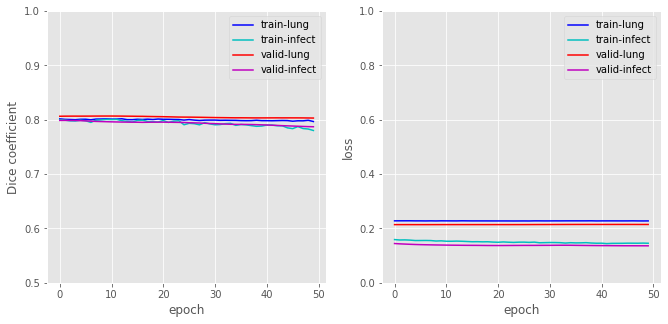

In [236]:
plt.style.use('ggplot')

fig, axes = plt.subplots(1, 2, figsize=(11,5))

axes[0].plot(ctsRes.history['lung_output_dice'], color='b', label='train-lung')
axes[0].plot(ctsRes.history['infect_output_dice'], color='c', label='train-infect')
axes[0].plot(ctsRes.history['val_lung_output_dice'], color='r', label='valid-lung')
axes[0].plot(ctsRes.history['val_infect_output_dice'], color='m', label='valid-infect')
axes[0].set_ylabel('Dice coefficient')
axes[0].set_xlabel('epoch')
axes[0].legend()
axes[0].set_ylim([0.5, 1])

axes[1].plot(ctsRes.history['lung_output_loss'], color='b', label='train-lung')
axes[1].plot(ctsRes.history['infect_output_loss'], color='c', label='train-infect')
axes[1].plot(ctsRes.history['val_lung_output_loss'], color='r', label='valid-lung')
axes[1].plot(ctsRes.history['val_infect_output_loss'], color='m', label='valid-infect')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylim([0,1])
axes[1].legend();

# 11. Testing

First load and process data from a test patient, predict output, and compare it with the true values.

In [254]:
cts = []
lungs = []
infects = []

glob_search = os.path.join(test_files[0], '*ctscan*.nii')
ct_file = glob.glob(glob_search)
ct = nib.load(ct_file[0])
data_cts = ct.get_fdata()

glob_search = os.path.join(test_files[0], '*lung*.nii')
lung_file = glob.glob(glob_search)
lung_masks = nib.load(lung_file[0])
data_lungs = lung_masks.get_fdata()

glob_search = os.path.join(test_files[0], '*infection*.nii')
infect_file = glob.glob(glob_search)
infect_masks = nib.load(infect_file[0])
data_infects = infect_masks.get_fdata()

height, width, slices = data_cts.shape
sel_slices = range(round(slices*0.2), round(slices*0.8))

data_cts = np.rot90(np.array(data_cts))
data_lungs = np.rot90(np.array(data_lungs))
data_infects = np.rot90(np.array(data_infects))

data_cts = np.reshape(np.rollaxis(data_cts, 2), (slices,height,width))
data_lungs = np.reshape(np.rollaxis(data_lungs, 2), (slices,height,width))
data_infects = np.reshape(np.rollaxis(data_infects, 2), (slices,height,width))

data_cts = data_cts[sel_slices, :, :]
data_lungs = data_lungs[sel_slices, :, :]
data_infects = data_infects[sel_slices, :, :]

for ii in range(data_cts.shape[0]):
    img_lungs = cv.resize(data_lungs[ii], dsize=(img_size, img_size), 
                            interpolation=cv.INTER_AREA)
    xmax, xmin = img_lungs.max(), img_lungs.min()
    img_lungs = (img_lungs - xmin)/(xmax - xmin)
    cropped_lungs, bounds = crop_img(img_lungs, [])
    lungs.append(cropped_lungs)

    img_ct = cv.resize(data_cts[ii], dsize=(img_size, img_size), 
                           interpolation=cv.INTER_AREA)
    xmax, xmin = img_ct.max(), img_ct.min()
    img_ct = (img_ct - xmin)/(xmax - xmin)
    clahe_ct = clahe_enhancer(img_ct, clahe, [])
    cropped_ct = crop_(clahe_ct, bounds)
    cts.append(cropped_ct)

    img_infec = cv.resize(data_infects[ii], dsize=(img_size, img_size), 
                              interpolation=cv.INTER_AREA)
    cropped_infec = crop_(img_infec, bounds)
    infects.append(cropped_infec)

In [255]:
del_lst = []
for ii in tqdm.tqdm(range(len(cts))) :
    try :
        cts[ii] = cv.resize(cts[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        cts[ii] = np.reshape(cts[ii], (num_pix, num_pix, 1))

        lungs[ii] = cv.resize(lungs[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        lungs[ii] = np.reshape(lungs[ii], (num_pix, num_pix, 1))

        infects[ii] = cv.resize(infects[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        infects[ii] = np.reshape(infects[ii], (num_pix, num_pix, 1))
    except :
        del_lst.append(ii)
        
for idx in del_lst[::-1] :
    del cts[idx]
    del lungs[idx]
    del infects[idx]

100%|██████████| 55/55 [00:00<00:00, 2104.75it/s]


In [264]:
cts = tf.convert_to_tensor(cts)/255
lungs = tf.convert_to_tensor(lungs)
infects = tf.convert_to_tensor(infects)

print(cts.shape, lungs.shape, infects.shape)

(55, 100, 100, 1) (55, 100, 100, 1) (55, 100, 100, 1)


In [274]:
test_result = ctsModel.evaluate(x=cts, 
                                y={'lung_output': lungs, 'infect_output': infects},
                                batch_size=batch_size);

print("Test data:\t\tloss\t\tdice coeff\n\t Lung:\t\t{:0.4f}\t\t{:0.4f}\n".format(
                test_result[1], test_result[3]),
                  "\t Infection:\t{:0.4f}\t\t{:0.4f}".format(test_result[2], 
                                                             test_result[4]))

Test data:		loss		dice coeff
	 Lung:		0.2294		0.7897
 	 Infection:	0.2579		0.7618


# 12. Visualize predicted outputs

In [275]:
yl_pred, yi_pred = ctsModel.predict(cts)

print(yl_pred.shape, yi_pred.shape)

(55, 100, 100, 1) (55, 100, 100, 1)


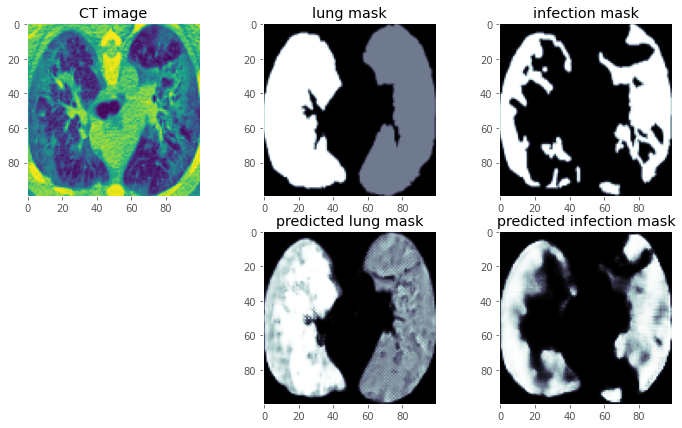

In [285]:
def compare_actual_and_predicted(img_num):

    fig = plt.figure(figsize=(12,7))

    plt.subplot(2,3,1)
    plt.imshow(tf.reshape(cts[img_num], [num_pix, num_pix]))
    plt.title('CT image'); plt.grid(None)

    plt.subplot(2,3,2)
    plt.imshow(tf.reshape(lungs[img_num], [num_pix, num_pix]), cmap='bone')
    plt.title('lung mask'); plt.grid(None)

    plt.subplot(2,3,3)
    plt.imshow(tf.reshape(infects[img_num], [num_pix, num_pix]), cmap='bone')
    plt.title('infection mask'); plt.grid(None)

    plt.subplot(2,3,5)
    plt.imshow(tf.reshape(yl_pred[img_num], [num_pix, num_pix]), cmap='bone')
    plt.title('predicted lung mask'); plt.grid(None)

    plt.subplot(2,3,6)
    plt.imshow(tf.reshape(yi_pred[img_num], [num_pix, num_pix]), cmap='bone')
    plt.title('predicted infection mask'); plt.grid(None)
    

compare_actual_and_predicted(40)

In [ ]:
# model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[sm.metrics.IOUScore(threshold=0.55)])